<a href="https://colab.research.google.com/github/Fed29/tutorials2021/blob/main/0_intro_material/Lab_02_Intro_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX
[JAX](https://jax.readthedocs.io/en/latest/jax.html) is a library to conduct machine learning research directly on NumPy-like code and data.

- It automatically differentiates python code and NumPy code (with [Autograd](https://github.com/hips/autograd)).
- It compiles and runs NumPy code efficiently on accelerators like GPU and TPU (with [XLA](https://www.tensorflow.org/xla)).

### JAX and random number generators
To use pseudo-random generators in JAX, you need to explicitely generate a random key, and pass it to the operations that work with random numbers (e.g. model initialization, dropout etc).

A call to a random function with the same key does not change the state of the generator. This has to be done explicitely with `split()` (or `next_rng_key()` in `haiku` transformed functions).

In [1]:
import jax.numpy as jnp
from jax import random

# Generating a single key will result in duplicate pseudo-random numbers
key = random.PRNGKey(0)
x1 = random.normal(key, (3,))
print(x1)
x2 = random.normal(key, (3,))
print(x2)

[ 1.8160863  -0.48262316  0.33988908]
[ 1.8160863  -0.48262316  0.33988908]


In [2]:
# Let's split the key to be able to generate different random values
key, new_key = random.split(key)
x1 = random.normal(key, (3,))
print(x1)
x2 = random.normal(new_key, (3,))
print(x2)

[ 0.13893168  0.509335   -0.53116107]
[ 1.1378784  -1.2209548  -0.59153634]


### JAX program transformations with examples 
* `jit` (just-in-time compilation) -- speeds up your code by running all the ops inside the jit-ed function as a *fused* op; it compiles the function when it is called the first time, and uses the compiled (optimized) version from the second call onwards.
* `grad` (automatic differentiation) -- returns derivatives of a function with respect to the model weights passed as parameters.
* `vmap` (automatic batching) -- returns a new function that can apply the original (per-sample) function to a batch.



**Just-in-time compilation**

A function can be "jit-ed" in two ways:
* by defining a new one as ``jit(original_function)`` (shown here)
* by using the ``@jit`` decorator in the function definition (shown later).


In [3]:
from jax import jit


# Function and input definition
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)


x = random.normal(key, (1000000,))

# Execute the function without jit
%timeit selu(x).block_until_ready()

# Execute the function with jit
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

The slowest run took 164.08 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.35 ms per loop
The slowest run took 447.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 253 µs per loop


Note: we used ``block_until_ready`` to time the function calls because JAX, by default, runs operations asynchronously.

**Automatic differentiation**

Also known as "autograd", automatic differentiation can be obtained in JAX by calling `grad(original_function)`.

In [4]:
from jax import grad, jit


# Function definition
def simple_fun(x):
    return jnp.sin(x) / x


# Get the gradient of simple_fun with respect to its input x
grad_simple_fun = grad(simple_fun)

# Get higher order derivatives of simple_fun (e.g. Hessian)
grad_grad_simple_fun = grad(grad(simple_fun))

Note: `grad_simple_fun()` accepts the same input type as `simple_fun()`.<br/>
So if we want to pass a vector in our example, we have to either use a list comprehension (shown here), or use a proper batching mechanism (shown later).

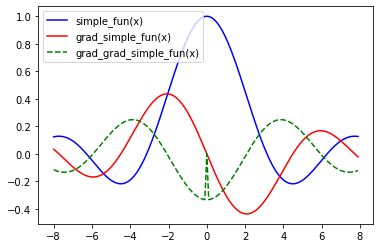

In [5]:
# Let's plot the result
import matplotlib.pyplot as plt
x_range = jnp.arange(-8, 8, .1)
plt.plot(x_range, simple_fun(x_range), 'b')
plt.plot(x_range, [grad_simple_fun(xi) for xi in x_range], 'r')
plt.plot(x_range, [grad_grad_simple_fun(xi) for xi in x_range], '--g')
plt.legend(('simple_fun(x)', 'grad_simple_fun(x)', 'grad_grad_simple_fun(x)'))
plt.show()

**Automatic batching**

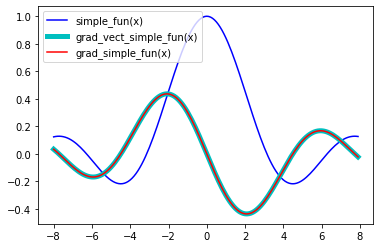

In [6]:
from jax import vmap

# In the example above, we can use vmap instead of loop to compute gradients
# (We stop at the first-order derivative)
grad_vect_simple_fun = vmap(grad_simple_fun)(x_range)

# Plot again and visually check that the gradients are identical
plt.plot(x_range, simple_fun(x_range), 'b')
plt.plot(x_range, grad_vect_simple_fun, 'c', linewidth=5)
plt.plot(x_range, [grad_simple_fun(xi) for xi in x_range], 'r')
plt.legend(('simple_fun(x)', 'grad_vect_simple_fun(x)', 'grad_simple_fun(x)'))
plt.show()

In [7]:
# Let's time them!

# naive batching
def naively_batched(x):
    return jnp.stack([grad_simple_fun(xi) for xi in x])


# manual batching with jit
@jit
def manual_batched(x):
    return jnp.stack([grad_simple_fun(xi) for xi in x])


# Batching using vmap and jit
@jit
def vmap_batched(x):
    return vmap(grad_simple_fun)(x)


print('Naively batched')
%timeit naively_batched(x_range).block_until_ready()
print('jit batched')
%timeit manual_batched(x_range).block_until_ready()
print('With jit vmap')
%timeit vmap_batched(x_range).block_until_ready()

Naively batched
1 loop, best of 3: 582 ms per loop
jit batched
The slowest run took 16655.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 303 µs per loop
With jit vmap
The slowest run took 685.43 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 207 µs per loop


### Read the doc for [common gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) in JAX!

# Haiku
[Haiku](https://github.com/deepmind/dm-haiku) is an object-oriented library to develop neural networks on top of JAX.

Notable entities:
* `hk.Module`: this is the base class for all layers and neural networks in Haiku.<br/>You can implement your own as a subclass of it: `class MyModule(hk.Module): [...]`
* `hk.transform`: this is used to convert modules (stateful elements) into pure functions (stateless elements).<br/>All JAX transformations (e.g. `jax.grad`) require you to pass in a pure function for correct behaviour.



**Example: Train a Multi-Layer Perceptron classifier (MLP) on the MNIST dataset**

In [8]:
# We will use haiku on top of jax

! pip install -q dm-haiku
! pip install -q optax

     |████████████████████████████████| 266kB 13.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 


In [9]:
import contextlib
from typing import Any, Mapping, Generator, Tuple

import haiku as hk

import jax
import optax  # package for optimizers
import jax.numpy as jnp
import numpy as np
import enum

# Dataset library
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Plotting library
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

# Don't forget to select GPU runtime environment
# in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# define some useful types
OptState = Any
Batch = Mapping[str, np.ndarray]

Found GPU at: /device:GPU:0


### Define the dataset: MNIST

MNIST dataset: [[Reference 1](http://yann.lecun.com/exdb/mnist/)] [[Reference 2](https://en.wikipedia.org/wiki/MNIST_database)]

In [11]:
# JAX does not support data loading or preprocessing,
# so we use TensorFlow datasets (tfds).
# We define a load_dataset() function that selectively imports,
# shuffles and batches part of MNIST.
# The function returns a Generator which produces batches of
# MNIST data.

NUM_CLASSES = 10

def load_dataset(split:str, *, is_training:bool, batch_size:int) -> Generator[Batch, None, None]:
    """Loads the dataset as a generator of batches."""
    ds = tfds.load('mnist:3.*.*', split=split).cache().repeat()
    if is_training:
        ds = ds.shuffle(10 * batch_size, seed=0)
    ds = ds.batch(batch_size)
    return tfds.as_numpy(ds)

In [12]:
# Make datasets for train and test
train_dataset = iter(load_dataset('train',
                                  is_training=True,
                                  batch_size=1000))
train_eval_dataset = iter(load_dataset('train',
                                       is_training=False,
                                       batch_size=10000))
test_eval_dataset = iter(load_dataset('test',
                                      is_training=False,
                                      batch_size=10000))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Define the classifier: a simple MLP

Architecture:
*   Flatten (unroll 28$\times$28 image into 784-long vector)
*   Linear mapping to 300-long vector (fully-connected)
*   ReLU (non-linearity)
*   Linear mapping to 100-long vector
*   ReLU
*   Linear mapping to the final problem size (10 classes)

In [13]:
def net_fn(batch: Batch) -> jnp.ndarray:
    """Standard LeNet-300-100 MLP network."""
    # The images are in [0, 255], uint8; 
    # we need to convert to float and normalize
    x = batch['image'].astype(jnp.float32) / 255.
    # We use hk.Sequential to chain the modules in the network
    mlp = hk.Sequential([
        # The input images are 28x28, so we first flatten them
        # to apply linear (fully-connected) layers
        hk.Flatten(),
        hk.Linear(300), jax.nn.relu,
        hk.Linear(100), jax.nn.relu,
        hk.Linear(10),
    ])
    return mlp(x)

``hk.transform`` turns functions that use object-oriented, functionally "impure" modules into pure functions that can be used with ``jax.jit``, ``jax.grad``, ``jax.pmap``, etc.

Note: since we do not store additional state statistics (e.g. as needed in batch norm), we use `hk.transform`.<br/>
If we define a `batch_norm` layer, we will use `hk.transform_with_state`

In [14]:
net = hk.transform(net_fn)

In [15]:
print(type(net_fn))
print(type(net))

<class 'function'>
<class 'haiku._src.transform.Transformed'>


### Define the optimizer

https://jax.readthedocs.io/en/latest/jax.experimental.optimizers.html

In [16]:
# We use Adam optimizer here. Others are possible, e.g. SGD with momentum.
lr = 1e-3
opt = optax.adam(lr)

### Define the optimization objective (loss function)

In [17]:
# Training loss: cross-entropy plus regularization weight decay
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
    """Compute the loss of the network, including L2 for regularization."""

    # Get network predictions
    logits = net.apply(params, None, batch)

    # Generate one_hot labels from index classes
    labels = jax.nn.one_hot(batch['label'], NUM_CLASSES)

    # Compute mean softmax cross entropy over the batch
    softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
    softmax_xent /= labels.shape[0]

    # Compute the weight decay loss by penalising the norm of parameters
    l2_loss = 0.5 * sum(jnp.sum(jnp.square(p))
                        for p in jax.tree_leaves(params))

    return softmax_xent + 1e-4 * l2_loss

### Evaluation metric

In [18]:
# Classification accuracy
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
    # Get network predictions
    predictions = net.apply(params, None, batch)
    # Return accuracy = how many predictions match the ground truth
    return jnp.mean(jnp.argmax(predictions, axis=-1) == batch['label'])

### Define training step (parameters update)

In [19]:
@jax.jit
def update(
    params: hk.Params,
    opt_state: OptState,
    batch: Batch,
) -> Tuple[hk.Params, OptState]:
    """Learning rule (stochastic gradient descent)."""
    # Use jax transformation `grad` to compute gradients;
    # it expects the parameters of the model and the input batch
    grads = jax.grad(loss)(params, batch)

    # Compute parameters updates based on gradients and optimizer state
    updates, opt_state = opt.update(grads, opt_state)

    # Apply updates to parameters
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

### Initialize the model and the optimizer

In [20]:
# Initialize model and optimizer; note that a sample input is needed to compute
# shapes of parameters

# Generate a data batch
batch = next(train_dataset)
# Initialize model
params = net.init(jax.random.PRNGKey(42), batch)
# Initialize optimizer
opt_state = opt.init(params)

### Visualize data and parameter shapes

In [21]:
# We define a gallery() function to display images

MAX_IMAGES = 10

def gallery(images, label, title='Input images'):
    class_dict = [u'zero', u'one', u'two', u'three',
                  u'four', u'five', u'six', u'seven',
                  u'eight', u'nine']
    num_frames, h, w, num_channels = images.shape
    num_frames = min(num_frames, MAX_IMAGES)
    ff, axes = plt.subplots(1, num_frames,
                            figsize=(30, 30),
                            subplot_kw={'xticks': [], 'yticks': []})
    if images.min() < 0:
        images = (images + 1.) / 2.
    for i in range(0, num_frames):
        if num_channels == 3:
            axes[i].imshow(np.squeeze(images[i]))
        else:
            axes[i].imshow(np.squeeze(images[i]), cmap='gray')
        axes[i].set_title(class_dict[label[i]], fontsize=28)
        plt.setp(axes[i].get_xticklabels(), visible=False)
        plt.setp(axes[i].get_yticklabels(), visible=False)
    ff.subplots_adjust(wspace=0.1)
    plt.show()

(1000, 28, 28, 1)
(1000,)


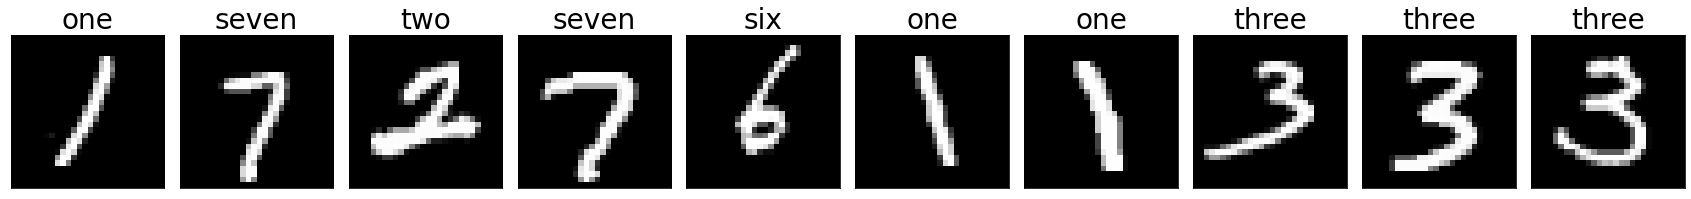

In [22]:
# Display shapes and images
print(batch['image'].shape)
print(batch['label'].shape)
gallery(batch['image'], batch['label'])

In [23]:
# Let's see how many parameters are in our network and their shapes
def get_num_params(params: hk.Params):
    num_params = 0
    for p in jax.tree_leaves(params):
        print(p.shape)
        num_params = num_params + np.prod(p.shape)
    return num_params

print('Total number of parameters %d' % get_num_params(params))

(300,)
(784, 300)
(100,)
(300, 100)
(10,)
(100, 10)
Total number of parameters 266610


### Accuracy of the untrained model (should be ~10%)

In [24]:
# Compute accuracy on the test dataset
test_accuracy = accuracy(params, next(test_eval_dataset))
print('Test accuracy %f ' % test_accuracy)

Test accuracy 0.131600 


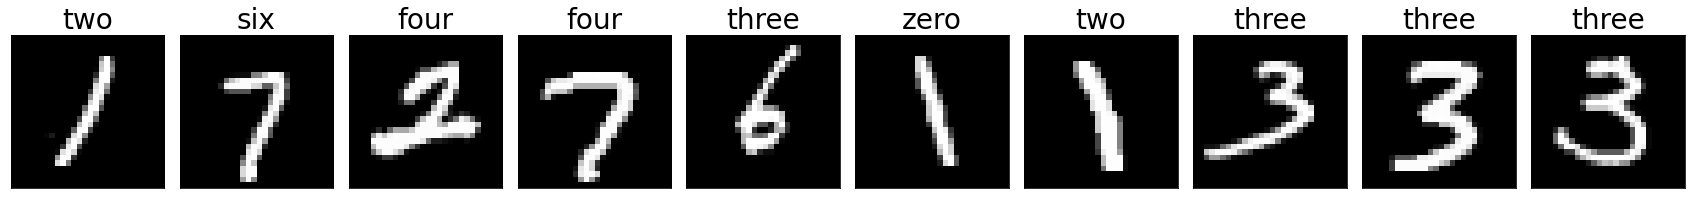

In [25]:
# Let's visualize some network predictions
# before training; if some are correct,
# they are correct by chance.
predictions = net.apply(params, None, batch)
pred_labels = jnp.argmax(predictions, axis=-1)
gallery(batch['image'], pred_labels)

### Run one training step

In [26]:
# First, let's do one step and check if the updates lead to decrease in error
loss_before_train = loss(params, batch)
print('Loss before train %f' % loss_before_train)
params, opt_state = update(params, opt_state, batch)
new_loss = loss(params, next(train_dataset))
new_loss_same_batch = loss(params, batch)
print('Loss after one step of training, same batch %f, different batch %f'
      % (new_loss_same_batch, new_loss))

Loss before train 2.314259
Loss after one step of training, same batch 2.221060, different batch 2.227546


### Run training steps in a loop. We also run evaluation periodically.

In [27]:
# Train/eval loop.
for step in range(5001):
    if step % 1000 == 0:
        # Periodically evaluate classification accuracy on train & test sets.
        train_accuracy = accuracy(params, next(train_eval_dataset))
        test_accuracy = accuracy(params, next(test_eval_dataset))
        train_accuracy, test_accuracy = jax.device_get(
            (train_accuracy, test_accuracy))
        print('Step %d Train / Test accuracy: %f / %f'
              % (step, train_accuracy, test_accuracy))

    # Do SGD on a batch of training examples.
    params, opt_state = update(params, opt_state, next(train_dataset))

Step 0 Train / Test accuracy: 0.394600 / 0.386300
Step 1000 Train / Test accuracy: 0.995100 / 0.979000
Step 2000 Train / Test accuracy: 0.999200 / 0.981000
Step 3000 Train / Test accuracy: 0.999700 / 0.981500
Step 4000 Train / Test accuracy: 0.999200 / 0.981800
Step 5000 Train / Test accuracy: 0.999100 / 0.981700


### Visualize network predictions after training. Most of the predictions should be correct.

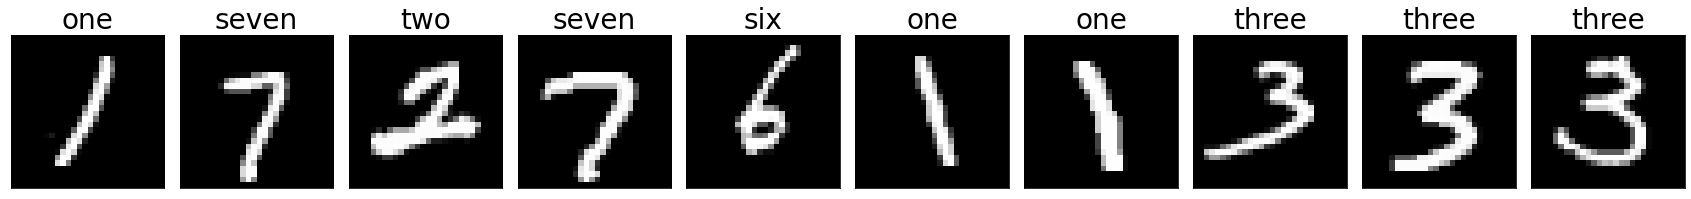

In [28]:
# Get predictions for the same batch
predictions = net.apply(params, None, batch)
pred_labels = jnp.argmax(predictions, axis=-1)
gallery(batch['image'], pred_labels)